In [1]:
import sys
sys.path.append('../')

from src.m4_generator import M4Generator
from src.m4_data_loader import M4DataLoader
from src.error_functions import *
from src.visualization import *
from src.evaluation import *
from src.m4_model import M4Model


import numpy as np
import keras
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

Using TensorFlow backend.


# Load Data

In [4]:
EPOCHS = 100
BATCH_SIZE = 50
LOOKBACK = 48
HORIZON = 48
HIDDEN_LAYER_SIZE = 200
LOSS = mase

data_loader = M4DataLoader("../Dataset/Train/Hourly-train.csv", "../Dataset/Test/Hourly-test.csv",
                  LOOKBACK, HORIZON,  validation_ratio=0.05)

train_x, train_y = data_loader.get_training_data()
test_x, test_y = data_loader.get_test_data()
validate_x, validate_y = data_loader.get_validation_data()

training_data_generator = M4Generator(train_x, train_y, BATCH_SIZE)
test_data_generator = M4Generator(test_x, test_y, BATCH_SIZE)
validation_data_generator = M4Generator(validate_x, validate_y, BATCH_SIZE)

# Train The Model

In [5]:
model = M4Model(hidden_layer_size=HIDDEN_LAYER_SIZE, batch_size=BATCH_SIZE, lookback=LOOKBACK, 
        output_size=HORIZON, learning_rate=0.001, loss = LOSS, dropout_ratio = 0.4)

model.train(training_data_generator, test_data_generator, epochs=EPOCHS)

hist = model.evaluate(validation_data_generator)
print(hist)

Epoch 1/100
129/129 [==============================] - 17s 134ms/step - loss: 1.7470 - val_loss: 1.7418
Epoch 2/100
129/129 [==============================] - 17s 131ms/step - loss: 1.4521 - val_loss: 1.5300
Epoch 3/100
129/129 [==============================] - 17s 132ms/step - loss: 1.3917 - val_loss: 1.3659
Epoch 4/100
129/129 [==============================] - 17s 133ms/step - loss: 1.3596 - val_loss: 1.3538
Epoch 5/100
129/129 [==============================] - 18s 136ms/step - loss: 1.3265 - val_loss: 1.3914
Epoch 6/100
129/129 [==============================] - 20s 158ms/step - loss: 1.2966 - val_loss: 1.4098
Epoch 7/100
129/129 [==============================] - 20s 152ms/step - loss: 1.2860 - val_loss: 1.4234
Epoch 8/100
129/129 [==============================] - 20s 153ms/step - loss: 1.2627 - val_loss: 1.6589
Epoch 9/100
129/129 [==============================] - 20s 159ms/step - loss: 1.2401 - val_loss: 1.3601
Epoch 10/100
129/129 [==============================] - 20s 154m

129/129 [==============================] - 19s 150ms/step - loss: 0.9324 - val_loss: 1.0130
Epoch 80/100
129/129 [==============================] - 19s 149ms/step - loss: 0.9337 - val_loss: 0.9663
Epoch 81/100
129/129 [==============================] - 20s 152ms/step - loss: 0.9298 - val_loss: 0.9855
Epoch 82/100
129/129 [==============================] - 21s 161ms/step - loss: 0.9197 - val_loss: 1.0022
Epoch 83/100
129/129 [==============================] - 21s 161ms/step - loss: 0.9283 - val_loss: 1.0680
Epoch 84/100
129/129 [==============================] - 21s 161ms/step - loss: 0.9233 - val_loss: 1.0738
Epoch 85/100
129/129 [==============================] - 20s 153ms/step - loss: 0.9328 - val_loss: 0.9718
Epoch 86/100
129/129 [==============================] - 20s 157ms/step - loss: 0.9208 - val_loss: 1.0006
Epoch 87/100
129/129 [==============================] - 19s 145ms/step - loss: 0.9178 - val_loss: 0.9925
Epoch 88/100
129/129 [==============================] - 17s 135ms/st

# Save The Model

In [6]:
MODEL_BASE_DIR = '../models/1-LSTM'
model.save(MODEL_BASE_DIR)

Saved model files to disk under../models/1-LSTM/3


# Get Best And Worst Predictions

Best Predection Error is    33.0114
Worst Predection Error is   141.4395


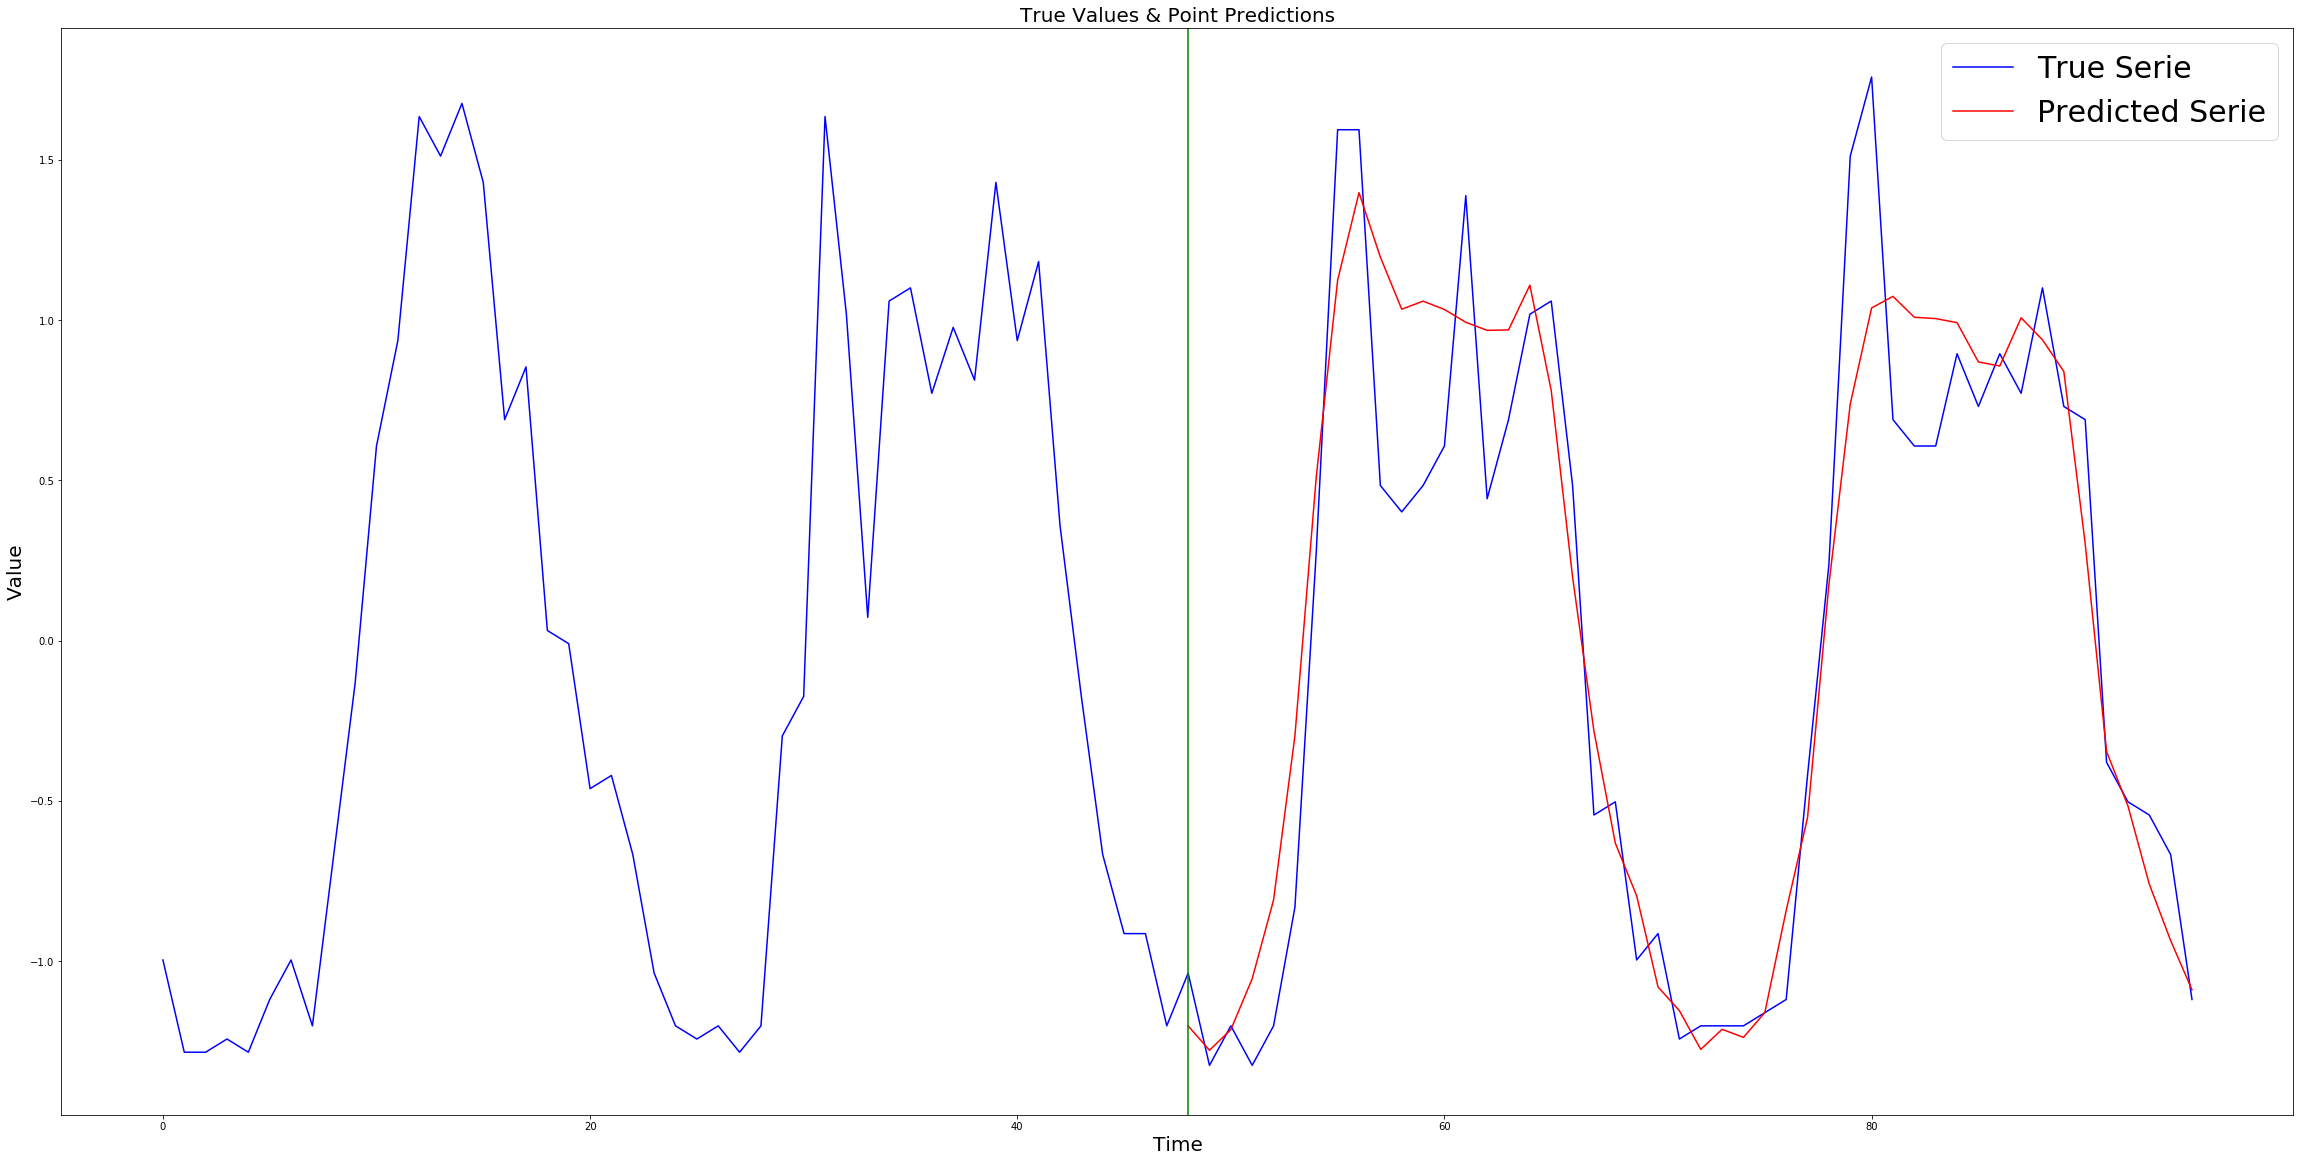

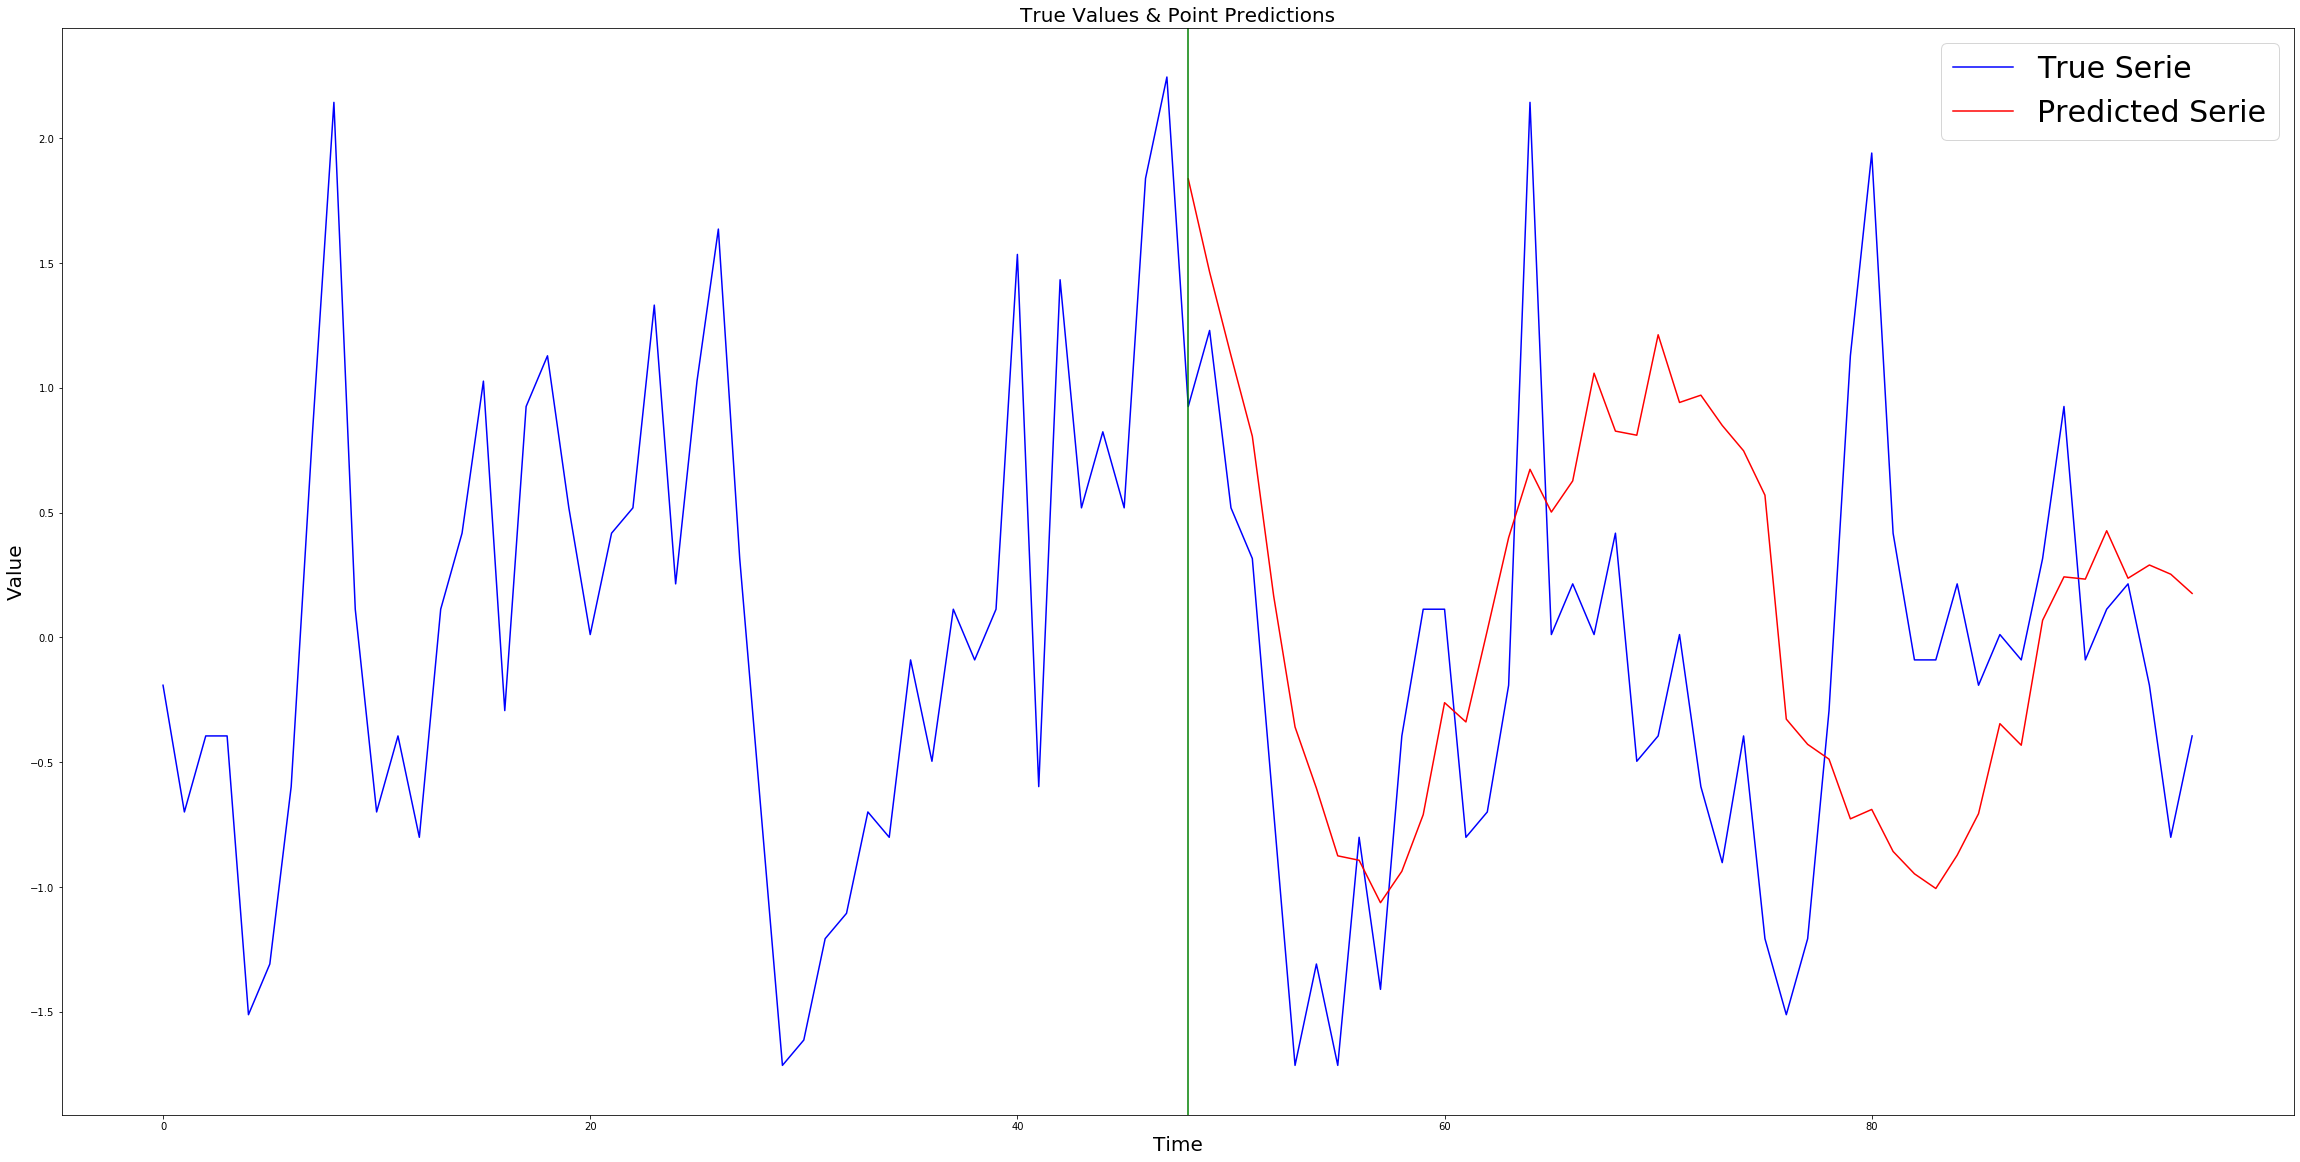

In [7]:
x, y, prediction, error =  sort_by_prediction_error(model, validate_x, validate_y, smape)

print(f'Best Predection Error is {error[0]:10.4f}')
print(f'Worst Predection Error is {error[x.shape[0]-1]:10.4f}')

plot_serie_and_prediction(x, y, prediction, serie_indx=0)
plot_serie_and_prediction(x, y, prediction, serie_indx= x.shape[0]-1)

# PLot Specific Serie From A Batch

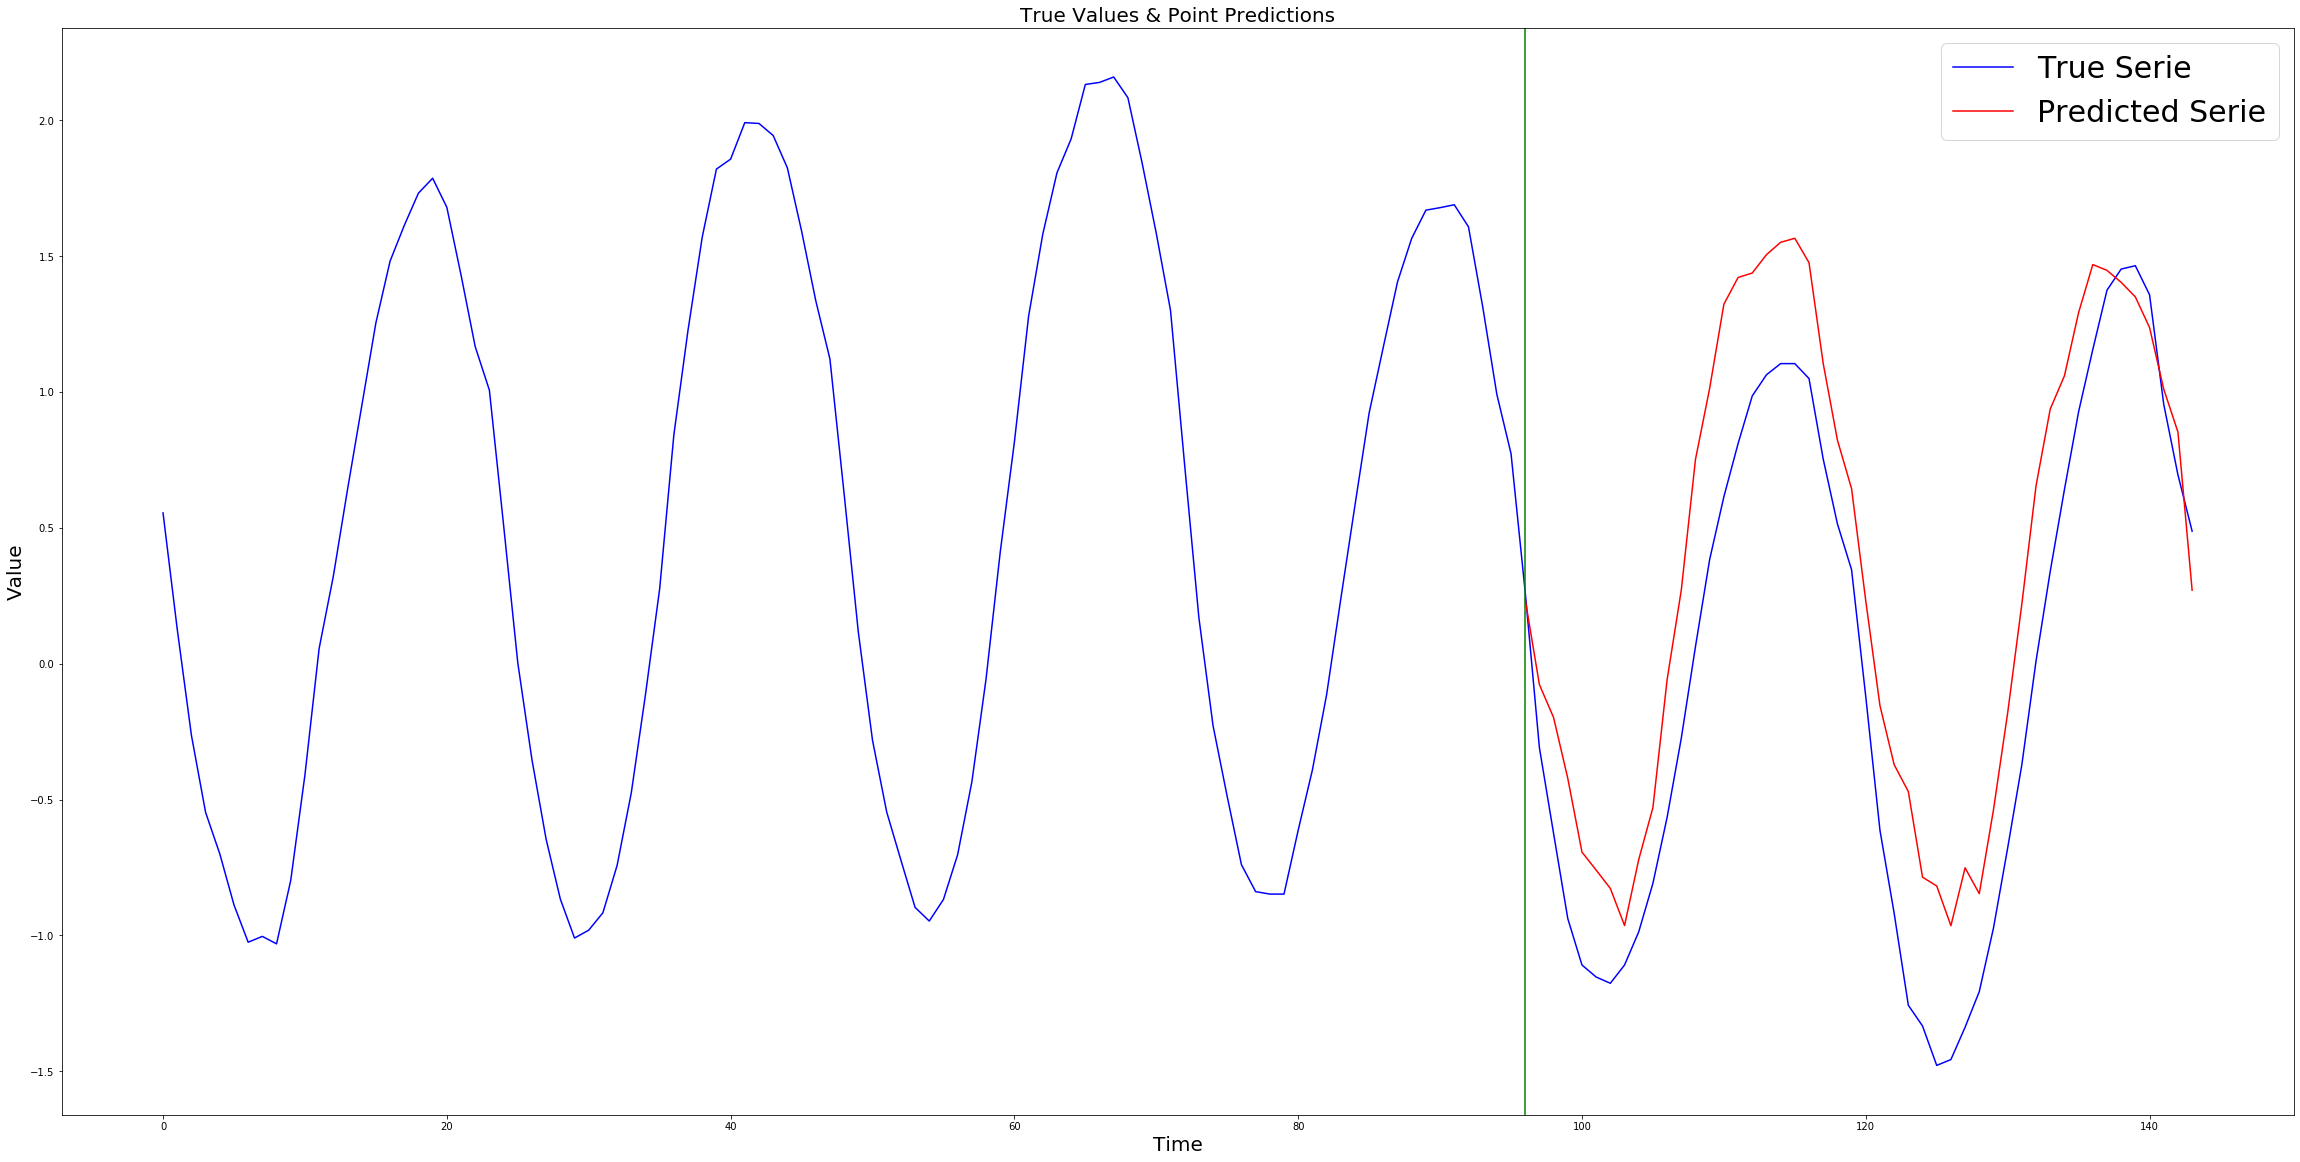

In [7]:
IDX = 1
#============ Predict Test
predictedY = model.predict(test_x[:BATCH_SIZE,:].reshape(BATCH_SIZE, LOOKBACK, 1))
#plot_series(test_x, test_y, predictedY, series_num=10)
plot_serie_and_prediction(test_x, test_y, predictedY, serie_indx=IDX)

# Evaluate A Model Against An Error Function

In [8]:
MODEL_NUMBER = 3
MODEL_BASE_DIR = '../models/1-LSTM'
training_error, test_error, validation_error = load_and_evaluate_model(f'{MODEL_BASE_DIR}/{MODEL_NUMBER}', 
                                                                       '../Dataset/Train/Hourly-train.csv', 
                                                                       '../Dataset/Test/Hourly-test.csv', mase)
print(f'Training Error For Model ({MODEL_NUMBER}) : {training_error}')
print(f'Test Error For Model ({MODEL_NUMBER}) : {test_error}')
print(f'Validation Error For Model ({MODEL_NUMBER}) : {validation_error}')

Loaded model from disk
Training Error For Model (3) : 0.8875
Test Error For Model (3) : 1.0267
Validation Error For Model (3) : 1.07
